In [1]:
from time import time
import os
import warnings
import numpy as np
from random import sample
from skimage.data import imread
from skimage.transform import resize
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.optimizers import adam
from keras import losses
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau,  EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
t0 = time()
warnings.filterwarnings('ignore')


def image_data(path, num_of_images=None):
    print('Loading Images')
    image = []
    n = 0  # dummy declaration
    for filename in os.listdir(path):
        img = imread(os.path.join(path, filename))
        img = resize(img, (64, 64))
        for i, s in enumerate(filename):
            if s is '_':
                n = int(filename[0:i])
        image.append([img, n])

    print('%0.3f sec' % (time() - t0))
    if num_of_images is None:
        image_sample = sample(image, len(image))
    else:
        image_sample = sample(image, num_of_images)
    labels = []
    image1 = []
    print('Splitting images and labels')
    for i in range(len(image_sample)):
        labels.append(image_sample[i][1])
        image1.append(image_sample[i][0])
    image1 = np.asarray(image1)
    labels = np.reshape(labels, (-1, 1))
    return image1, labels

Image, Target = image_data('regression_data')


Loading Images
172.548 sec
Splitting images and labels


In [24]:
scaler = MinMaxScaler()
print('Splitting into train and test data')
X_train, X_test, y_train, ytest = train_test_split(Image, Target, test_size=0.2)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(ytest)


def regressor_fun():
    print('Load the regressor function and build the model')
    clf = Sequential()
    clf.add(BatchNormalization(input_shape=(64, 64, 3)))
    clf.add(Conv2D(32, (3, 3), activation='relu', bias_initializer='glorot_normal', padding='same'))
    clf.add(Conv2D(32, (3, 3), activation='relu', bias_initializer='glorot_normal', padding='same'))
    clf.add(MaxPooling2D())
    clf.add(Conv2D(64, (3, 3), activation='relu', bias_initializer='glorot_normal', padding='same'))
    clf.add(Conv2D(64, (3, 3), activation='relu', bias_initializer='glorot_normal', padding='same'))
    clf.add(MaxPooling2D())
    clf.add(Conv2D(128, (3, 3), activation='relu', bias_initializer='glorot_normal', padding='same'))
    clf.add(GlobalMaxPooling2D())
    clf.add(BatchNormalization())
    clf.add(Dense(64, activation='relu', bias_initializer='glorot_normal'))
    clf.add(Dense(units=1, activation='sigmoid', bias_initializer='glorot_normal'))
    
    opt = adam(lr=0.001)
    clf.compile(optimizer=opt, loss='mse', metrics=['mae'])
    clf.summary()
    return clf

print('Call the regressor')
model = regressor_fun()



Splitting into train and test data
Call the regressor
Load the regressor function and build the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 64)        36928     
________________________________________

In [25]:
stop = EarlyStopping(monitor='val_loss', patience=15, min_delta=1e-5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)
t0 = time()
print('\nFit the data to the model')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.4, callbacks=[reduce_lr, stop])
print('\nTime taken for training is --->  %0.2f sec' % (time() - t0))


Fit the data to the model
Train on 2893 samples, validate on 1929 samples
Epoch 1/100
2893/2893 [==============================] - 126s - loss: 0.0259 - mean_absolute_error: 0.1206 - val_loss: 0.0667 - val_mean_absolute_error: 0.2265
Epoch 2/100
2893/2893 [==============================] - 129s - loss: 0.0122 - mean_absolute_error: 0.0816 - val_loss: 0.0617 - val_mean_absolute_error: 0.2114
Epoch 3/100
2893/2893 [==============================] - 129s - loss: 0.0092 - mean_absolute_error: 0.0704 - val_loss: 0.0918 - val_mean_absolute_error: 0.2337
Epoch 4/100
2893/2893 [==============================] - 130s - loss: 0.0079 - mean_absolute_error: 0.0656 - val_loss: 0.0235 - val_mean_absolute_error: 0.1148
Epoch 5/100
2893/2893 [==============================] - 129s - loss: 0.0064 - mean_absolute_error: 0.0587 - val_loss: 0.0408 - val_mean_absolute_error: 0.1516
Epoch 6/100
2893/2893 [==============================] - 130s - loss: 0.0062 - mean_absolute_error: 0.0588 - val_loss: 0.0145

2893/2893 [==============================] - 144s - loss: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 0.0028 - val_mean_absolute_error: 0.0369
Epoch 52/100
2893/2893 [==============================] - 140s - loss: 0.0014 - mean_absolute_error: 0.0282 - val_loss: 0.0028 - val_mean_absolute_error: 0.0369
Epoch 53/100
2893/2893 [==============================] - 141s - loss: 0.0013 - mean_absolute_error: 0.0257 - val_loss: 0.0028 - val_mean_absolute_error: 0.0369
Epoch 54/100
2893/2893 [==============================] - 134s - loss: 0.0013 - mean_absolute_error: 0.0270 - val_loss: 0.0028 - val_mean_absolute_error: 0.0370

Time taken for training is --->  7658.77 sec


In [26]:
print('\nPrediction of Test data')
y = model.predict(X_test)
print('\n  Mean Sq error  =  {0}  Mean Sq log error = {1}'.format(mean_squared_error(y_test, y),
                                                                 mean_squared_log_error(y_test, y)))
print('\n  R2 score  =  {}'.format(r2_score(y_true=y_test, y_pred=y)))


yp = scaler.inverse_transform(y)
print('\nUnscaled targets:')
print("\n  Mean absolute error = {}".format(mean_absolute_error(ytest, yp)))
print('\n  Mean Sq error  =  {0}  Mean Sq log error = {1}'.format(mean_squared_error(ytest, yp),
                                                                 mean_squared_log_error(ytest, yp)))



Prediction of Test data

  Mean Sq error  =  0.0030216883911605096  Mean Sq log error = 0.001712750975230749

  R2 score  =  0.9552050346738343

Unscaled targets:

  Mean absolute error = 6.503485611619839

  Mean Sq error  =  87.32679540972502  Mean Sq log error = 0.09280194284236273


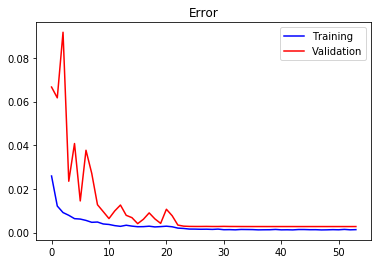

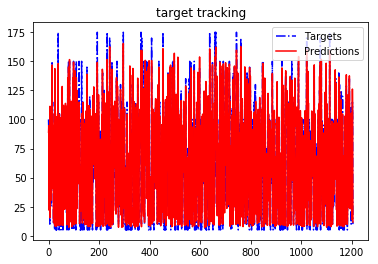

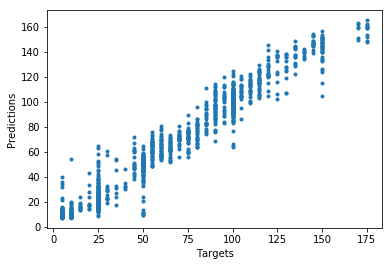

In [27]:
# Plots
x_ = np.arange(len(history.epoch))
plt.figure(1)
plt.title('Error')
plt.plot(x_, history.history['loss'], 'b', label='Training')
plt.plot(x_, history.history['val_loss'], 'r', label='Validation')
plt.legend()
plt.show()
plt.figure(2)
plt.title('target tracking')
x_ = np.arange(len(y_test))
plt.plot(x_, ytest, 'b-.', label='Targets')
plt.plot(x_, yp, 'r', label='Predictions')
plt.legend()
plt.show()
plt.figure(3)
plt.plot(ytest, yp, '.')
plt.ylabel('Predictions')
plt.xlabel('Targets')
plt.show()